In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
from glob import glob

In [2]:
%load_ext autoreload
%autoreload 1
%aimport data_utils
%aimport contrastive_data
%aimport sc_eVIP.score
%aimport main

In [3]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *


In [4]:
from sc_eVIP import score as sceVIP_score

# Data

In [5]:
gene = 'KRAS'
data_path = f'/home/lguirardel/data/perturb_comp/data/{gene}/'


In [6]:
group_wt_like = True
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=False)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		97 variant classes


In [157]:
metadata = pd.read_csv(paths[4], index_col=0) # contains T2 scores and control status
metadata['Control status'].value_counts()
metadata['Variant functional class'] = metadata['Variant functional class'].replace('Impactful IV (gain-of-function)', 'Impactful IV')

In [8]:
control_status = metadata['Control status'].dropna().isin(['synonymous'])
control_status.value_counts()


Control status
False    85
True     16
Name: count, dtype: int64

Ursu et al subsampled to 1k cell/variant, which is conserved here

In [9]:
counts.variant.value_counts()

variant
A130V    1000
G75A     1000
Q25H     1000
Q22H     1000
M170L    1000
         ... 
Q61K      599
K5E       529
G12S      498
G12D      496
G12V      406
Name: count, Length: 97, dtype: int64

In [10]:
metadata.loc['G13R']

Gene                                                                                      KRAS
Position: base(s)                                                                           37
From ORF base(s)                                                                             G
To ORF base(s)                                                                               C
Position: amino acid(s)                                                                     13
From amino acid(s)                                                                           G
To amino acid(s)                                                                             R
From ORF codon(s)                                                                          GGC
To ORF codon(s)                                                                            CGC
Mutation type                                                                           Single
Control status                                    

# PCA

Reproduce results from Ursu et al. They used all data, and so will we here

In [11]:
pca = PCA(20)
df = counts.drop(columns=['variant','Variant functional class',])
X_red = pca.fit_transform(df)
X_red = pd.DataFrame(X_red, index = df.index)

In [12]:
result = sceVIP_score.compare_groups_with_reference(

    X_red,
    pd.DataFrame(counts.variant.rename('label')),
    groups=counts.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 15/15 controls
1 %

100 %

In [13]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
A130V,39.15401,30.505302,47.802718,0.054595,0.040876,0.068313,0.552972,0.660218
Q25H,479.22924,437.224023,521.234457,0.097884,0.075171,0.120598,0.000010,0.384127
T144T,30.584535,24.766206,36.402864,0.051858,0.037572,0.066145,0.636952,0.656913
K5E,653.787668,616.483836,691.0915,0.981599,0.939167,1.02403,0.000010,0.000010
G12V,5058.672503,4894.764758,5222.580248,1.936389,1.923455,1.949324,0.000010,0.000010
...,...,...,...,...,...,...,...,...
R135T,49.632455,41.871117,57.393793,0.076169,0.056119,0.096219,0.358391,0.530461
T144P,365.526027,340.48909,390.562965,0.49689,0.447422,0.546358,0.000010,0.000010
N26Y,860.959483,815.982132,905.936833,1.237872,1.204197,1.271546,0.000010,0.000010
AG11TD,6332.340163,6111.384189,6553.296138,1.94214,1.930329,1.953952,0.000010,0.000010


        Recomputed        Paper
M111L    26.305927    26.248723
S136N    26.920392    26.672454
K179R    30.091336    29.958400
V8V      30.173677    30.347129
T144T    30.584535    30.545139
...            ...          ...
Q61L   9580.482312  9515.380160
G13R    9610.81203  9582.732490
G13D           NaN          NaN
G12L           NaN          NaN
Q70Q           NaN          NaN

[102 rows x 2 columns]


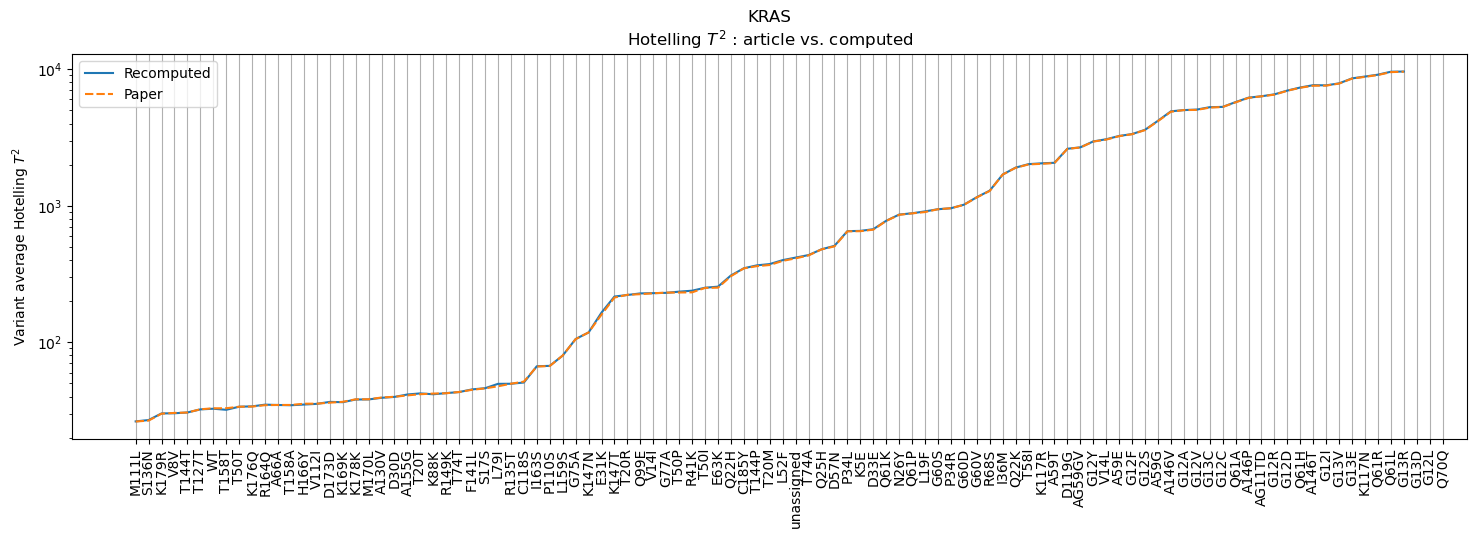

In [14]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename('Recomputed'), metadata['HotellingT2'].rename('Paper')), axis=1) #.dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
print(df)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ : article vs. computed')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x');


In [15]:
df[df.isna().any(axis=1)]

,Recomputed,Paper
H166Y,NaN,35.441848
unassigned,NaN,411.459204
G13D,NaN,NaN
G12L,NaN,NaN
Q70Q,NaN,NaN


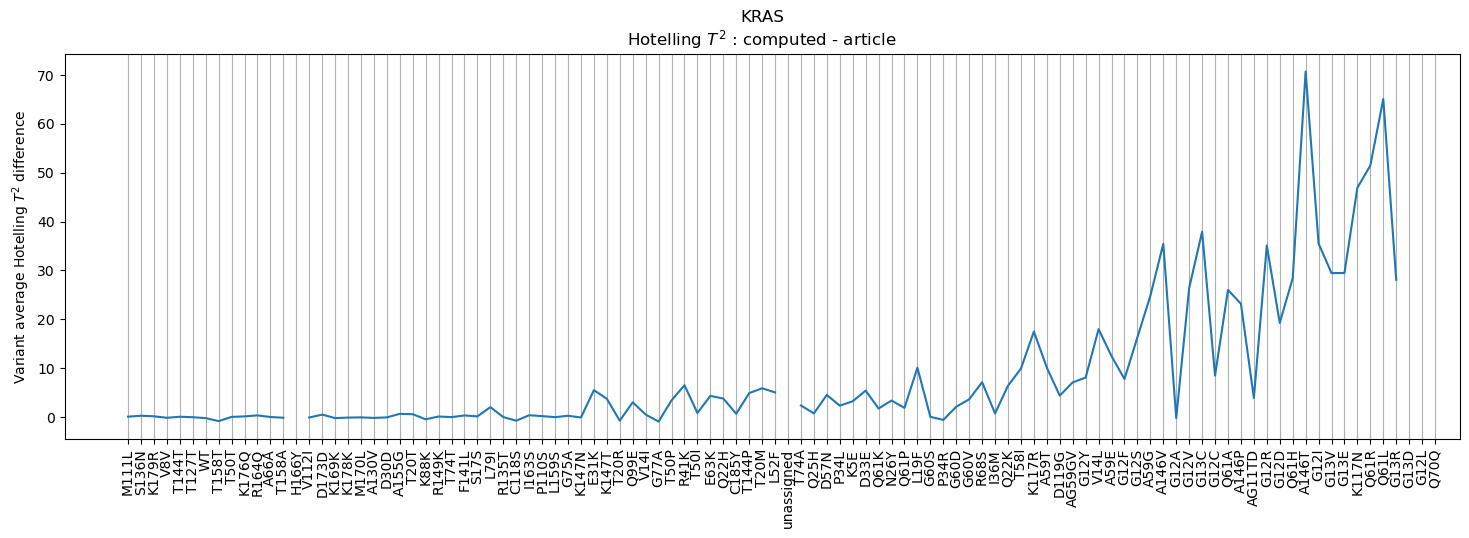

In [16]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)
plt.title(f'{gene}\nHotelling $T^2$ : computed - article')
plt.ylabel('Variant average Hotelling $T^2$ difference');

Nb : the difference observed here has some randomness. I suspect this might be due to the package used to compute Hotellings $T^2$. ~~I don't think it has a 0 expectancy, which means there's still likely to be something wrong.~~ It actually might have 0 expectancy, which means I might be worried for nothing

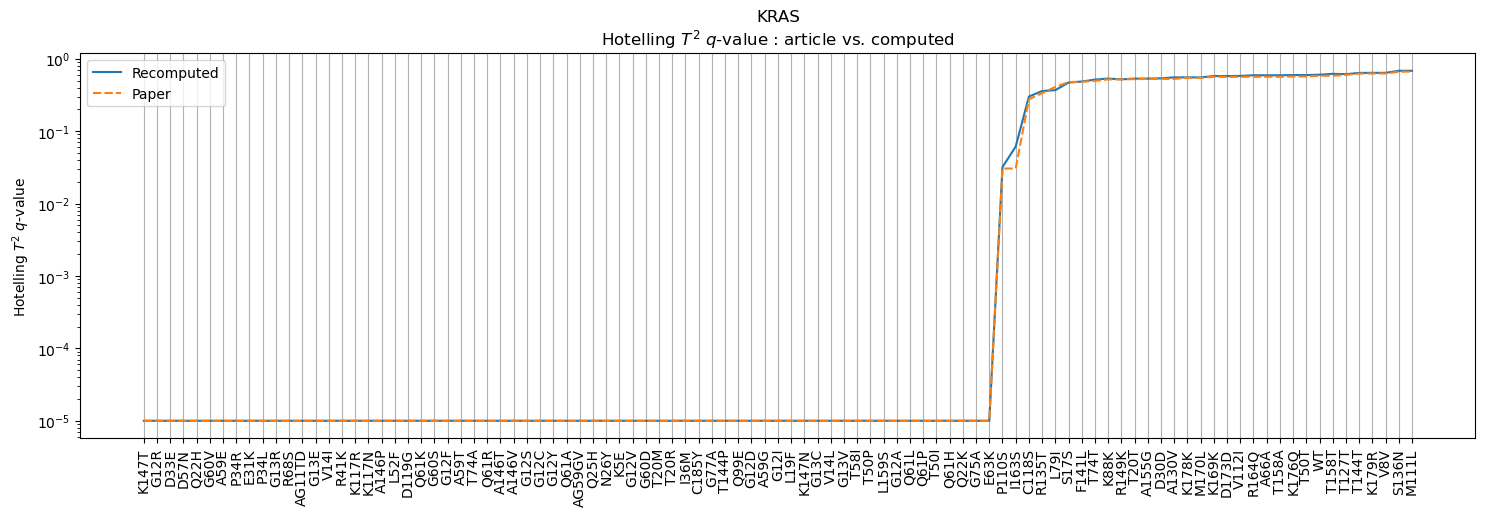

In [17]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename('Recomputed'), metadata['HotellingT2.q'].rename('Paper')), axis=1).dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
# print(df)
plt.grid(axis='x')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ $q$-value : article vs. computed')
plt.ylabel('Hotelling $T^2$ $q$-value');

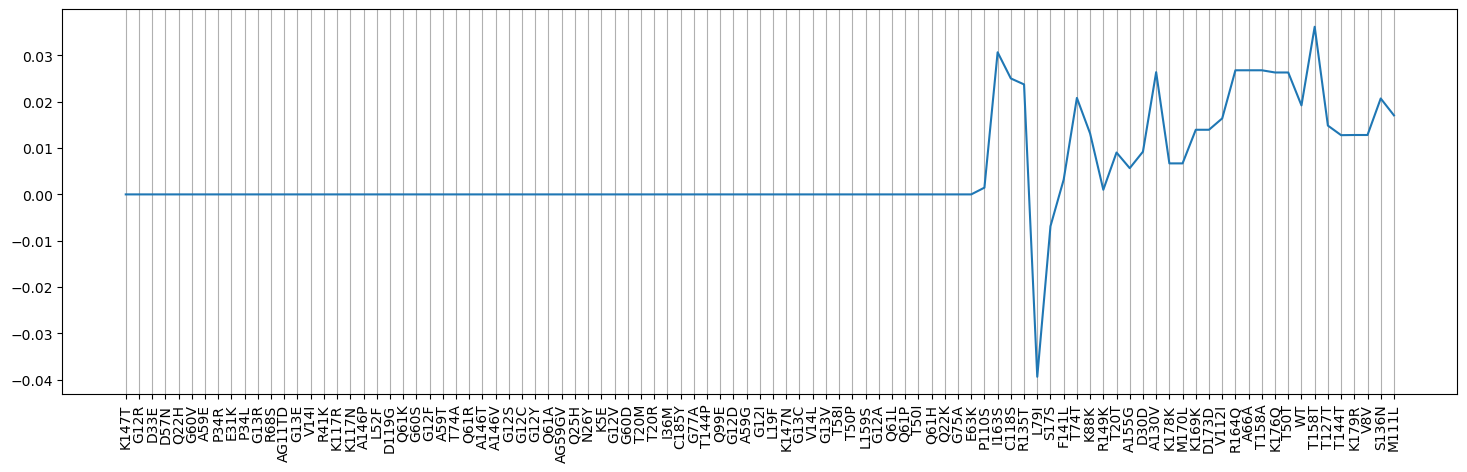

In [18]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)

# Model

In [137]:
run_name = 'KRAS_008_split'
dir_name = join('models',run_name)
! cat models/{run_name}/config.ini

weight-decay = 0.005
batch-size = 256
split-synon = true
task = siamese
loss = standard
margin = 1
alpha = 0
dropout = 0.2
positive-fraction = 0.5
lr = 0.001
n-epochs = 400
shape = [100, 100]
embed-dim = 20
n-workers = 0
knn = 3


In [152]:
! cat  models/{run_name}/best_score.json

{
  "3_nn_ref_seen": 0.04285540852252034,
  "i": 190
}

In [138]:
save_dir = f'plots/var_scores/{run_name}'
make_dir_if_needed(save_dir)

## Test run : not an actual good scoring protocol

### Embeddings

In [139]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, reorder_categories=False)
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

/home/lguirardel/work/sc_contrast/main.py:91: UserWarning: Not reordering categories will lead to wrong classifier prediction
  warn('Not reordering categories will lead to wrong classifier prediction')


73 variants in train
24 variants in unseen


In [140]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

Siamese(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1145, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=100, out_features=20, bias=True)
    )
  )
)

In [141]:
emb_dict = {}
for k, df in df_dict.items():
    X = torch.tensor(df.drop(columns=['variant','Variant functional class', ]).to_numpy(), dtype=torch.float32)
    embeds = []
    for i,x in enumerate(X):
        with torch.no_grad():
            embeds.append(model.network.forward(x))
    emb_dict[k] = torch.stack(embeds)

In [142]:
emb_dim = emb_dict['train'].size(1)
print("Embedding dimension :", emb_dim)

Embedding dimension : 20


### Scoring

In [143]:
subset = 'train' #unseen does not mean much as we have too few controls
df = df_dict[subset]
embeds = emb_dict[subset]

# embeds = (embeds - embeds.mean(dim=0, keepdim=True))/embeds.std(dim=0, keepdim=True)

In [144]:
result = sceVIP_score.compare_groups_with_reference(
    pd.DataFrame(embeds, index=df.index),
    pd.DataFrame(df.variant.rename('label')),
    groups=df.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 13/13 controls
2 %

100 %

In [145]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
A130V,53.233705,42.465705,64.001704,0.004958,0.003686,0.00623,0.543210,0.486907
T20T,44.595484,37.760912,51.430055,0.003779,0.003102,0.004455,0.630037,0.590278
V14I,251.853533,230.462657,273.244409,0.03317,0.030899,0.035441,0.000010,0.000010
G12A,5776.181584,5506.775225,6045.587943,0.68038,0.670978,0.689782,0.000010,0.000010
D173D,62.991853,55.332412,70.651293,0.005122,0.004478,0.005767,0.440275,0.450928
...,...,...,...,...,...,...,...,...
K147T,276.83114,251.572532,302.089749,0.029101,0.027149,0.031052,0.000010,0.000010
G75A,161.48131,144.506033,178.456586,0.014463,0.012901,0.016026,0.000010,0.000010
G13E,8756.584474,8376.621926,9136.547021,1.050608,1.039978,1.061238,0.000010,0.000010
R68S,1893.358628,1767.378881,2019.338375,0.243602,0.233737,0.253467,0.000010,0.000010


In [146]:
## code reproduced from https://github.com/klarman-cell-observatory/sc_eVIP/, 

def get_threshold_at_FDR(fdr_data,scorename,signame,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[signame]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=False)
    score_thresh_value=float(list(fdr_passed[scorename])[0])
    return(score_thresh_value)

In [147]:
model_thr = get_threshold_at_FDR(result, scorename='HotellingT2.mean',signame='HotellingT2.q',
        FDR = 0.05)
PCA_thr = get_threshold_at_FDR(metadata, scorename='HotellingT2',signame='HotellingT2.q',
        FDR = 0.05)

### Figures

In [168]:
variant_class_cmap = {
    'Synonymous':'C7',
    'WT-like':'C4',
    'Impactful I':'C2',
    'Impactful II':'C5',
    'Impactful III':'C6',
    'Impactful IV':'C3',
}


In [164]:
def color_tick(ticklabel, ):
    variant = ticklabel.get_text()
    color = 'k'
    if control_status[variant ] :
        color = variant_class_cmap['Synonymous']
    else:
        color = variant_class_cmap[metadata.loc[variant, 'Variant functional class']]
        # if metadata.loc[variant, 'Variant functional class']=='WT-like':
        #     ticklabel.set_color('orange')   
    ticklabel.set_color(color)



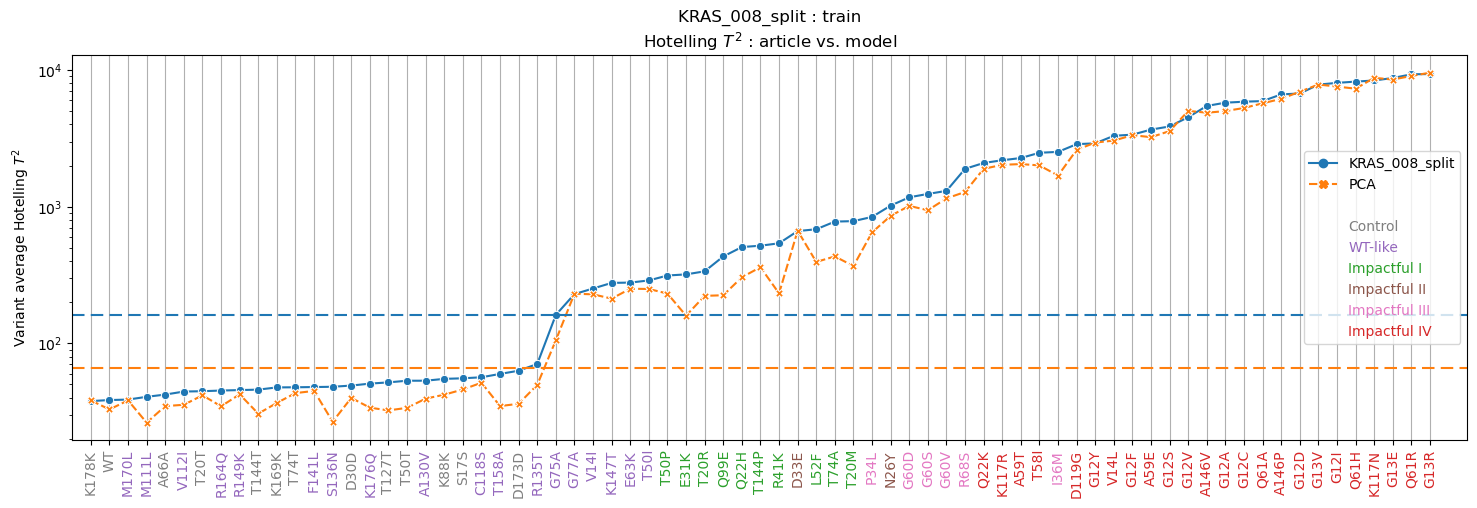

In [170]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename(run_name), metadata['HotellingT2'].rename('PCA')), axis=1).dropna()
df = df.sort_values(run_name)
sns.lineplot(data=df, markers=True)
plt.yscale('log')
plt.xticks(rotation=90)

ax = plt.gca()
dashes = [6,3] 
plt.axhline(model_thr, color='C0', dashes = dashes)
plt.axhline(PCA_thr, color='C1', dashes = dashes)

for ticklabel in plt.gca().get_xticklabels():
    color_tick(ticklabel)

plt.title(f'{run_name} : {subset}\nHotelling $T^2$ : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x')
# text legends
plt.axvspan(1,2, facecolor='w', alpha=0, label=' ')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Control')
plt.axvspan(1,2, facecolor='w', alpha=0, label='WT-like')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful I')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful II')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful III')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful IV')
plt.legend(labelcolor = ['k','k','k',*variant_class_cmap.values()])
plt.xlim(-1, df.shape[0]+1)
plt.savefig(save_dir+f'/{subset}_T2.pdf');


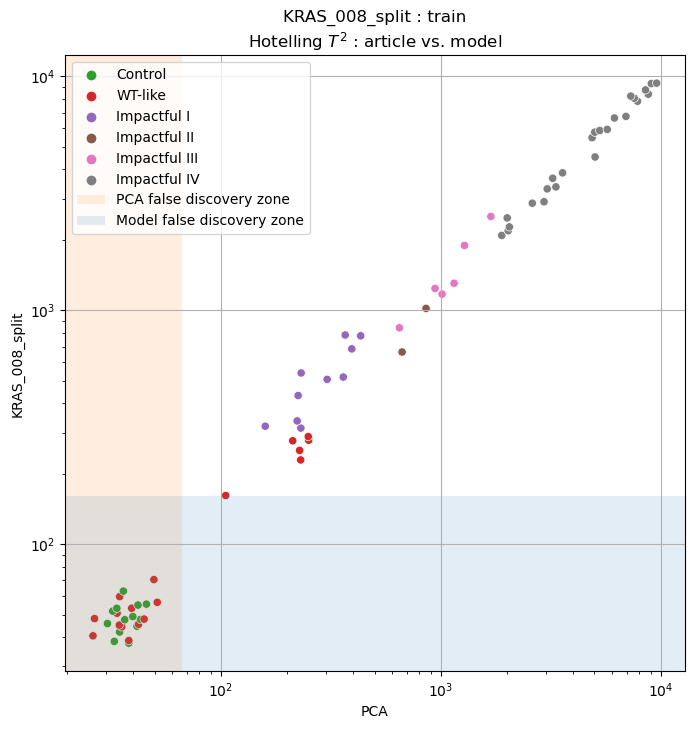

In [162]:
plt.gcf().set_size_inches(8, 8);

hue = metadata.loc[df.index, 'Variant functional class'].copy()
hue[metadata['Control status'] == 'synonymous'] = 'Synonymous'
sns.scatterplot(df, x='PCA', y=run_name, hue=hue, palette=variant_class_cmap, hue_order=variant_class_cmap.keys())
plt.title(f'{run_name} : {subset}\nHotelling $T^2$ : article vs. model')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.axvspan(0, PCA_thr, facecolor='C1', alpha=1/8, label='PCA false discovery zone')
plt.axhspan(0, model_thr, facecolor='C0', alpha=1/8, label='Model false discovery zone')
plt.legend()
plt.savefig(save_dir+f'/{subset}_T2_scatter.pdf');

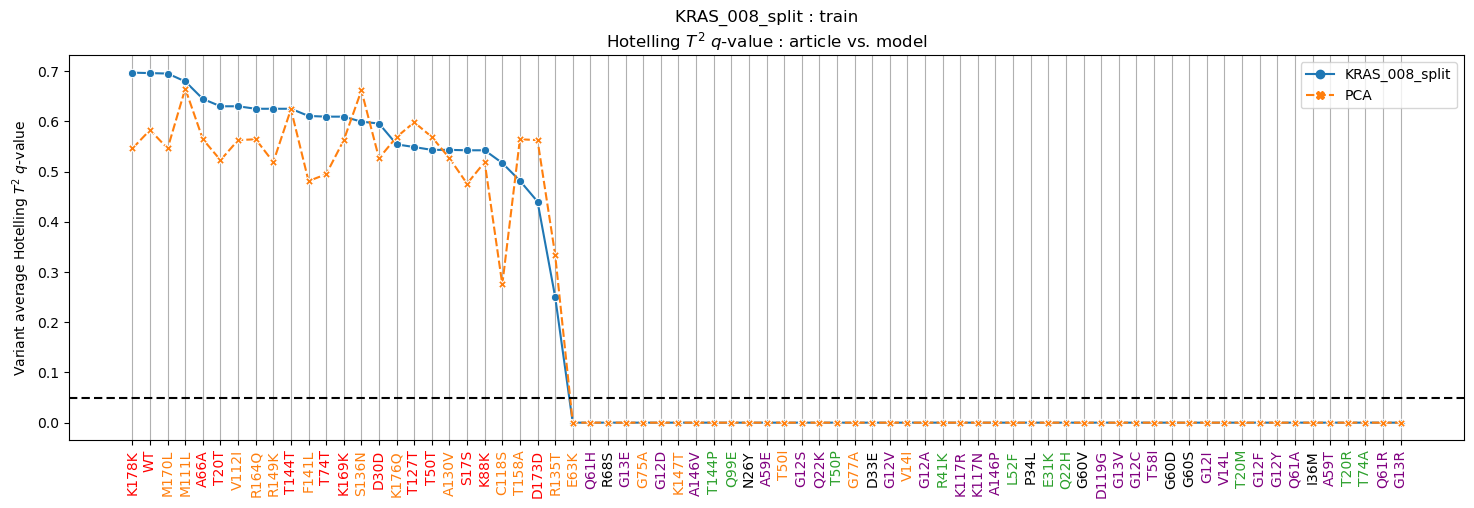

In [151]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename(run_name), metadata['HotellingT2.q'].rename('PCA')), axis=1).dropna()
df = df.sort_values(run_name, ascending=False)
sns.lineplot(data=df, markers=True)
# plt.yscale('log')
plt.xticks(rotation=90)

for ticklabel in plt.gca().get_xticklabels():
   color_tick(ticklabel)

plt.title(f'{run_name} : {subset}\nHotelling $T^2$ $q$-value : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$ $q$-value')
plt.grid(axis='x')
plt.axhline(0.05, dashes=[4,2], color='k')
plt.savefig(save_dir+f'/{subset}_T2_q.pdf');